# Datasets creation

In [1]:
from datasets import load_dataset
from map_generation.osm_dataset import TextToImageDataset
from torchvision.transforms.functional import to_pil_image
from transformers import CLIPTokenizer
import os
import pandas as pd
from tqdm import tqdm
from itertools import product
from functional import seq
from srai.loaders.osm_loaders.filters import HEX2VEC_FILTER

/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.10/site-packages/srai/loaders/_base.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to

# Prepare data

In [2]:
def _flatten_tags(tags):
    tags_flat = (
        seq(tags.items())
        .starmap(lambda k, v: product([k], v if isinstance(v, list) else [v]))
        .flatten()
        .map(lambda x: "_".join(x))
        .list()
    )
    return tags_flat
columns = _flatten_tags(HEX2VEC_FILTER)
columns[:5]

['aeroway_aerodrome',
 'aeroway_apron',
 'aeroway_gate',
 'aeroway_hangar',
 'aeroway_helipad']

# Saving metadata to image folders
Code creates csv with tags in each city's tiles folder. Metadata.csv is used to generate captions.

Due to changes in srai.SippyMapRegionizer this code does not run with embeddings present in drive. You can skip this step - on drive are folders with created metadata.csv or use freshly created embeddings with previous notebook.

In [7]:
for city in tqdm(os.listdir("../data/tiles")):
    if os.path.exists(f"../data/embeddings/{city}.pkl"):
        df = pd.read_pickle(f"../data/embeddings/{city}.pkl")
        df = df.reindex(columns=columns, fill_value=0)
        df["file_name"] = df.apply(lambda row: f"{row.name[0]}_{row.name[1]}.png", axis=1)
        df = df.set_index("file_name")
        path = f"../data/tiles/{city}/metadata.csv"
        print(f"saving to {path}")
        df.to_csv(path)
    else :
        print(city, "not found")

100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

saving to ../data/tiles2/Wroclaw, Poland/metadata.csv


# Get prepared data and push to huggingface hub

In [5]:
ds = TextToImageDataset("../data/tiles/Wrocław, PL")


Resolving data files: 100%|██████████| 2145/2145 [00:00<00:00, 70410.03it/s]
Found cached dataset imagefolder (/home/marcin/.cache/huggingface/datasets/imagefolder/Wrocław, PL-16adbde1af182d57/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)
100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


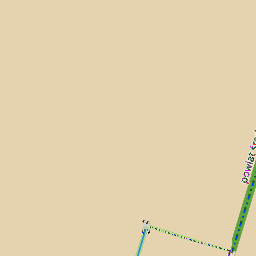

In [10]:
to_pil_image(ds[0][0])

In [ ]:
hds = ds.to_huggingface_dataset()
hds.push_to_hub("mprzymus/osm_tiles_small")

In [14]:
text = ds[0][1]
text

tensor([49406,  3923,   539,  2445, 20281,   281,   272,  1567,  1483, 45258,
          272,  3288,  1704,   269, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [16]:
from map_generation.config import BASE_MODEL_NAME

tokenizer = CLIPTokenizer.from_pretrained(BASE_MODEL_NAME, subfolder="tokenizer")
tokenizer.decode(text)

'<|startoftext|>map of area containing : 1 landuse farmland 1 natural wood. <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

In [3]:
large_ds = load_dataset("../data/tiles/")
large_ds.push_to_hub("mprzymus/osm_tiles_large")

Resolving data files: 100%|██████████| 135611/135611 [00:01<00:00, 117838.97it/s]


Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 1026.76it/s]


Dataset imagefolder downloaded and prepared to /home/marcin/.cache/huggingface/datasets/imagefolder/tiles-bb44cbe6b3b6f93d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
Pushing split train to the Hub.
Pushing dataset shards to the dataset hub: 100%|██████████| 7/7 [09:13<00:00, 79.10s/it]


# Check download works

In [3]:

ds = TextToImageDataset("mprzymus/osm_tiles_small")
ds

Found cached dataset parquet (/home/marcin/.cache/huggingface/datasets/mprzymus___parquet/mprzymus--osm_tiles_small-199229e0bb266c92/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/2144 [00:00<?, ? examples/s]